In [20]:
import numpy as np
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML


plt.rcParams['animation.writer'] = 'avconv'

%matplotlib inline

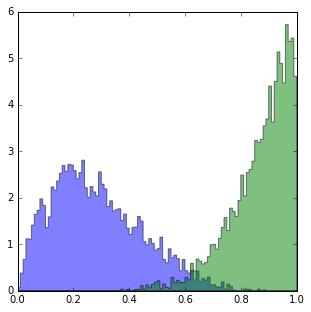

In [21]:
s_raw = np.random.beta(8,1.2, 4000)
b_raw = np.random.beta(2,5, 4000)

weight =np.concatenate((np.random.binomial(10,0.5, 4000)/100.0,np.random.binomial(10,0.5, 4000)/1.0))
y =np.concatenate((np.ones(s_raw.shape[0]),np.zeros(b_raw.shape[0])))

data = np.concatenate((s_raw,b_raw))

fig = plt.figure(figsize=(5,5))
bb,_,_ = plt.hist(data[y==0], bins=100, range=[0,1],weights=weight[y==0], histtype='stepfilled', alpha=0.5, normed=True)
ss,_,_ = plt.hist(data[y==1], bins=100, range=[0,1],weights=weight[y==1], histtype='stepfilled', alpha=0.5, normed=True)
# plt.yscale('log')
plt.show()

In [72]:
from scipy import optimize

class binner_base(object):
    """ Abstract class for classification based binning
    """
    def __init__(self, nbins, range):
        self.nbins = nbins
        self.range = range
        raise NotImplementedError('Method or function has not been implemented yet')
    def fit(self, X, y, sample_weights=None):
        raise NotImplementedError('Method or function has not been implemented yet')
        return self

    
class zbinner(binner_base):
    def __init__(self,nbins, range, drop_last_bin=True, 
                 fix_upper=True, fix_lower=False):
        self.nbins = nbins
        self.range = range
        self.drop_last_bin = drop_last_bin
        self.X = None
        self.y = None
        self.fix_upper = fix_upper
        self.fix_lower = fix_lower
        self.breg = 0
        self.sample_weights = None
        self.scan = {"bounds": [],"cost": []}
    def _fom_(self,s,b,breg=0):
        if s.any() < 0 :  s[s<0] = 0
        if b.any() < 0 :  b[b<0] = 0
        c = s / np.sqrt(s + b)
        c[s==0] = 0
        c[b==0] = 0
        #c = np.sqrt(2*((s+b+breg)*np.log(1+np.true_divide(s,b+breg))-s))
        return c
    def binned_score(self,x):
        if self.fix_upper and x[self.nbins]>self.range[1]: x[self.nbins] = self.range[1]
        if self.fix_lower and x[0]<self.range[0]: x[0] = self.range[0]
        if x.any() > self.range[1] : return np.zeros(x.shape)
        if x.any() < self.range[0] : return np.zeros(x.shape)
        x = np.sort(x)
        nb_,_  = np.histogram(self.X[self.y==0],bins=x, range=self.range, weights=self.sample_weights[self.y==0])
        ns_,_  = np.histogram(self.X[self.y==1],bins=x, range=self.range, weights=self.sample_weights[self.y==1])
        if nb_.shape !=  ns_.shape :
            return 0
        else:
            return self._fom_(ns_, nb_)
    def cost_fun(self,x):
        z  = self.binned_score(x)
        self.scan['bounds'].append(x)
        self.scan['cost'  ].append(-(z**2).sum()) 
        return -(z**2).sum()
    def fit(self, X, y, sample_weights=None):
        self.X = X
        self.y = y 
        if sample_weights is not None:
            self.sample_weights = sample_weights
        else:
            self.sample_weights = np.ones(X.shape[0])
        x_init = np.linspace (self.range[0],self.range[1],self.nbins+1)
        np.random.seed(555)
        min_args = {"method": "BFGS"}
        bounds   = [ self.range for i in range(self.nbins)]
        print'[bounds] = ', bounds
        res = optimize.basinhopping(self.cost_fun, x_init, 
                                    minimizer_kwargs=min_args, 
                                    niter=5000)
        return res

In [73]:
ncat    = 5
binner  = zbinner(ncat,[0,1])
results = binner.fit(data, y, sample_weights = weight)

[bounds] =  [[0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]


/home/user/.local/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in divide


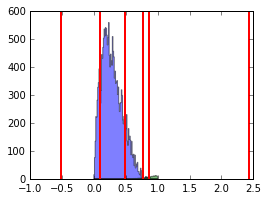

In [74]:
fig = plt.figure(figsize=(4,3))
plt.hist(data[y==0], bins=100, range=[0,1],weights=weight[y==0], histtype='stepfilled', alpha=0.5)
plt.hist(data[y==1], bins=100, range=[0,1],weights=weight[y==1], histtype='stepfilled', alpha=0.5)
for b in np.sort(results.x):
    plt.axvline(x=b, linewidth=2.0, color='red')
# plt.yscale('log')
plt.show()

In [75]:
np.array(binner.scan['bounds'])[:,0]

array([  0.0000e+00,   1.4901e-08,   0.0000e+00, ...,   1.0137e-01,
         1.0137e-01,   1.0137e-01])

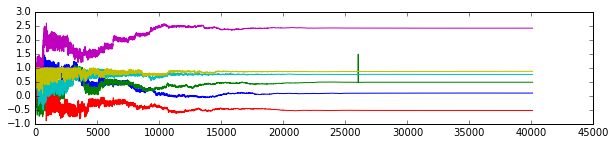

In [76]:
fig = plt.figure(figsize=(10,2))
for ix in range(results.x.shape[0]):
    plt.plot(range(np.array(binner.scan['bounds']).shape[0]), np.array(binner.scan['bounds'])[:,ix] )

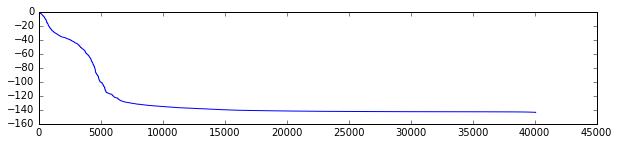

In [77]:
fig = plt.figure(figsize=(10,2))
plt.plot(range(np.array(binner.scan['bounds']).shape[0]), -np.sort(-np.array(binner.scan['cost'])) )

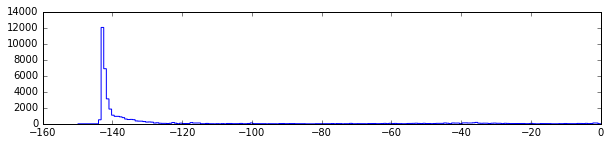

In [79]:
fig = plt.figure(figsize=(10,2))
plt.hist(np.array(binner.scan['cost']),bins=200,range=[-150,0], histtype='step')
plt.show()

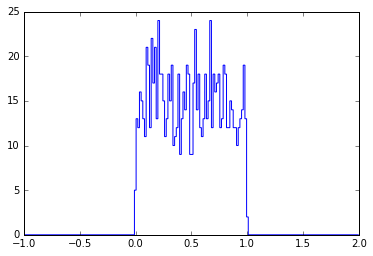

In [84]:
s = 0.5
plt.hist(np.random.uniform(0,1, 1000),bins=200,range=[-1,2], histtype='step')
plt.show()

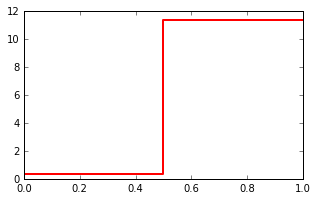

In [17]:
fig = plt.figure(figsize=(5,3))

plt.step(range(binner.nbins), binner.binned_score(np.sort(results.x)), linewidth=2.0, color='red',where='mid')
plt.show()

In [14]:
fig = plt.figure(figsize=(5,3))
x = np.arange(-2.0, 2.0, 0.01)
z = []
for ix in x :
    z.append(binner.cost_fun([ix,np.sort(results.x)[0],np.sort(results.x)[1]]))
plt.plot(x,z)
plt.axvline(x=np.sort(results.x)[1], linewidth=2.0, color='red')

IndexError: list index out of range

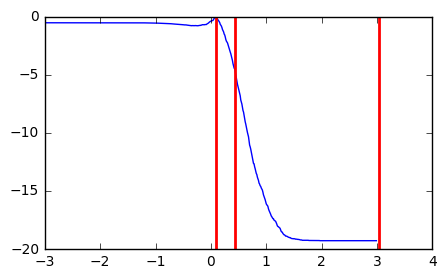

In [33]:
fig = plt.figure(figsize=(5,3))
x = np.arange(-3.0, 3.0, 0.01)
z = []
for ix in x :
    z.append(binner.cost_fun([np.sort(results.x)[0],ix]))
plt.plot(x,z)
for b in results.x:
    plt.axvline(x=b, linewidth=2.0, color='red')

/usr/lib/python2.7/dist-packages/matplotlib/animation.py:782: UserWarning: MovieWriter ffmpeg unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


RuntimeError: Error creating movie, return code: 1 Try running with --verbose-debug

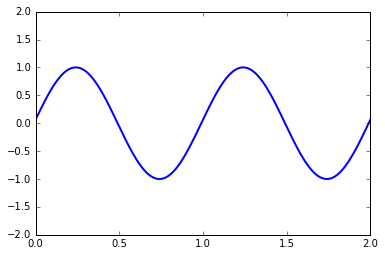

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.gif', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()